In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

!pip -q install --force-reinstall "protobuf==3.20.3" tqdm

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, time
from tqdm.auto import trange
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)

print("TF", tf.__version__)
print("GPU", tf.config.list_physical_devices('GPU'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
google-cloud-bigtable 2.32.0 requires google-api-core[grpc]<3.0.0,>=2.17.0, but you have google-api-core 1.34.1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]

2025-10-30 15:57:13.542343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761839833.564058     261 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761839833.570978     261 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF 2.18.0
GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
IMG = 128
BS  = 1
LR  = 2e-4
BETA1 = 0.5
LAM_C = 10.0
LAM_I = 5.0
EPOCHS = 10
STEPS  = 600


In [3]:
!mkdir -p /kaggle/working/data && cd /kaggle/working/data && wget -q https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip && unzip -q apple2orange.zip && rm apple2orange.zip
DATA_DIR = "/kaggle/working/data/apple2orange"

def _decode(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG, IMG), antialias=True)
    img = (tf.cast(img, tf.float32)/127.5) - 1.0
    return img

def _augment(x):
    return tf.image.random_flip_left_right(x)

def _pipe(glob):
    ds = tf.data.Dataset.list_files(glob, shuffle=True)
    ds = ds.map(_decode, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(_augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(800).repeat().batch(BS).prefetch(tf.data.AUTOTUNE)
    return ds

dsA = _pipe(f"{DATA_DIR}/trainA/*.jpg")
dsB = _pipe(f"{DATA_DIR}/trainB/*.jpg")
itA, itB = iter(dsA), iter(dsB)

def _pipe_test(glob):
    ds = tf.data.Dataset.list_files(glob, shuffle=True)
    ds = ds.map(_decode, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
    return ds

testA_imgs = _pipe_test(f"{DATA_DIR}/testA/*.jpg")
testB_imgs = _pipe_test(f"{DATA_DIR}/testB/*.jpg")

xa0 = next(iter(testA_imgs))[0]
xb0 = next(iter(testB_imgs))[0]
print("ok data:", xa0.shape, xb0.shape)


I0000 00:00:1761840044.685407     261 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


ok data: (128, 128, 3) (128, 128, 3)


In [4]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kw):
        super().__init__(**kw); self.epsilon=epsilon
    def build(self, s):
        self.gamma = self.add_weight(name='gamma', shape=(s[-1],), initializer='ones',  trainable=True)
        self.beta  = self.add_weight(name='beta',  shape=(s[-1],), initializer='zeros', trainable=True)
    def call(self,x):
        m,v=tf.nn.moments(x,[1,2],keepdims=True)
        x=(x-m)/tf.sqrt(v+self.epsilon)
        return self.gamma*x+self.beta

Norm = InstanceNormalization

def ResBlock(f):
    def fn(x):
        y = layers.Conv2D(f,3,padding='same')(x); y=Norm()(y); y=layers.ReLU()(y)
        y = layers.Conv2D(f,3,padding='same')(y); y=Norm()(y)
        return layers.ReLU()(layers.Add()([x,y]))
    return fn

def Gen():
    inp = layers.Input((IMG,IMG,3))
    x = layers.Conv2D(64,7,padding='same')(inp); x=Norm()(x); x=layers.ReLU()(x)
    for f in [128,256]:
        x = layers.Conv2D(f,3,strides=2,padding='same')(x); x=Norm()(x); x=layers.ReLU()(x)
    for _ in range(6):
        x = ResBlock(256)(x)
    for f in [128,64]:
        x = layers.Conv2DTranspose(f,3,strides=2,padding='same')(x); x=Norm()(x); x=layers.ReLU()(x)
    out = layers.Conv2D(3,7,padding='same',activation='tanh', dtype='float32')(x)
    return Model(inp, out)

def to_vgg(x):
    x = (x+1.0)*127.5
    return vgg_pre(x)

def Dis():
    inp = layers.Input((IMG,IMG,3))
    x = layers.Conv2D(64,4,strides=2,padding='same')(inp); x=layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128,4,strides=2,padding='same')(x); x=layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256,4,strides=2,padding='same')(x); x=layers.LeakyReLU(0.2)(x)
    patch = layers.Conv2D(1,4,padding='same')(x)
    vinp = layers.Lambda(to_vgg)(inp)
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(IMG,IMG,3))
    vgg.trainable=False
    feat = vgg(vinp)
    feat = layers.GlobalAveragePooling2D()(feat)
    aux = layers.Dense(128, activation='relu')(feat)
    aux = layers.Dense(1)(aux)
    return Model(inp, [patch, aux])

G_AB, G_BA = Gen(), Gen()
D_A,  D_B  = Dis(), Dis()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mae = tf.keras.losses.MeanAbsoluteError()

def d_loss(rp, ra, fp, fa):
    lr = bce(tf.ones_like(rp), rp) + bce(tf.ones_like(ra), ra)
    lf = bce(tf.zeros_like(fp), fp) + bce(tf.zeros_like(fa), fa)
    return 0.5*(lr+lf)

def g_adv(fp, fa):
    return bce(tf.ones_like(fp), fp) + bce(tf.ones_like(fa), fa)

opt_G  = tf.keras.optimizers.Adam(LR, beta_1=BETA1)
opt_DA = tf.keras.optimizers.Adam(LR, beta_1=BETA1)
opt_DB = tf.keras.optimizers.Adam(LR, beta_1=BETA1)


In [6]:
CKPT_DIR = "/kaggle/working/cyclegan_ckpt"
ckpt = tf.train.Checkpoint(G_AB=G_AB, G_BA=G_BA, D_A=D_A, D_B=D_B, opt_G=opt_G, opt_DA=opt_DA, opt_DB=opt_DB)
manager = tf.train.CheckpointManager(ckpt, CKPT_DIR, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)
print("CKPT:", manager.latest_checkpoint if manager.latest_checkpoint else "None")


CKPT: None


In [7]:
dummy = tf.zeros((1, IMG, IMG, 3), dtype=tf.float32)
_ = G_AB(dummy); _ = G_BA(dummy); _ = D_A(dummy); _ = D_B(dummy)


I0000 00:00:1761840149.078854     261 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [8]:
@tf.function(reduce_retracing=True)
def _step(a,b):
    with tf.GradientTape(persistent=True) as t:
        fb = G_AB(a, training=True)
        fa = G_BA(b, training=True)
        ca = G_BA(fb, training=True)
        cb = G_AB(fa, training=True)
        ida = G_BA(a, training=True)
        idb = G_AB(b, training=True)
        p_fb, ax_fb = D_B(fb, training=True)
        p_fa, ax_fa = D_A(fa, training=True)
        p_rb, ax_rb = D_B(b,  training=True)
        p_ra, ax_ra = D_A(a,  training=True)
        Lg  = g_adv(p_fb, ax_fb) + g_adv(p_fa, ax_fa) + LAM_C*(mae(a,ca)+mae(b,cb)) + LAM_I*(mae(a,ida)+mae(b,idb))
        Lda = d_loss(p_ra,ax_ra,p_fa,ax_fa)
        Ldb = d_loss(p_rb,ax_rb,p_fb,ax_fb)
    gvars = G_AB.trainable_variables + G_BA.trainable_variables
    opt_G.apply_gradients(zip(t.gradient(Lg, gvars), gvars))
    opt_DA.apply_gradients(zip(t.gradient(Lda, D_A.trainable_variables), D_A.trainable_variables))
    opt_DB.apply_gradients(zip(t.gradient(Ldb, D_B.trainable_variables), D_B.trainable_variables))
    return Lg, Lda, Ldb

for ep in range(1, EPOCHS+1):
    t0 = time.time()
    for s in range(STEPS):
        a = next(itA); b = next(itB)
        Gtot, DA, DB = _step(a,b)
        if (s+1) % 100 == 0:
            tf.print("ep", ep, s+1, "/", STEPS, "| G:", tf.round(Gtot*1000)/1000, "DA:", tf.round(DA*1000)/1000, "DB:", tf.round(DB*1000)/1000)
        if (s+1) % 200 == 0:
            manager.save()
    print("epoch", ep, round(time.time()-t0,1), "s"); manager.save()


ep 1 100 / 600 | G: 27.535 DA: 0.732 DB: 0.126
ep 1 200 / 600 | G: 33.579 DA: 0.291 DB: 0.133
ep 1 300 / 600 | G: 34.051 DA: 3.202 DB: 0.059
ep 1 400 / 600 | G: 36.261 DA: 2.775 DB: 0.39
ep 1 500 / 600 | G: 25.39 DA: 1.548 DB: 0.196
ep 1 600 / 600 | G: 40.892 DA: 0.22 DB: 0.396
epoch 1 178.0 s
ep 2 100 / 600 | G: 35.736 DA: 0.272 DB: 0.582
ep 2 200 / 600 | G: 41.677 DA: 0.158 DB: 0.379
ep 2 300 / 600 | G: 37.103 DA: 0.185 DB: 0.053
ep 2 400 / 600 | G: 21.836 DA: 0.701 DB: 5.558
ep 2 500 / 600 | G: 45.006 DA: 0.334 DB: 0.393
ep 2 600 / 600 | G: 32.552 DA: 1.425 DB: 0.246
epoch 2 129.8 s
ep 3 100 / 600 | G: 21.885 DA: 1.425 DB: 0.262
ep 3 200 / 600 | G: 20.073 DA: 0.498 DB: 0.681
ep 3 300 / 600 | G: 28.813 DA: 0.294 DB: 0.572
ep 3 400 / 600 | G: 47.805 DA: 0.221 DB: 0.289
ep 3 500 / 600 | G: 37.343 DA: 0.137 DB: 0.444
ep 3 600 / 600 | G: 50.116 DA: 0.032 DB: 0.123
epoch 3 129.8 s
ep 4 100 / 600 | G: 26.417 DA: 0.417 DB: 0.926
ep 4 200 / 600 | G: 37.56 DA: 0.463 DB: 0.134
ep 4 300 / 600 |

In [9]:
print("Checkpoint actual:", manager.latest_checkpoint)


Checkpoint actual: /kaggle/working/cyclegan_ckpt/ckpt-40


In [11]:
G_AB.save("/kaggle/working/generator_apple2orange.keras")
G_BA.save("/kaggle/working/generator_orange2apple.keras")


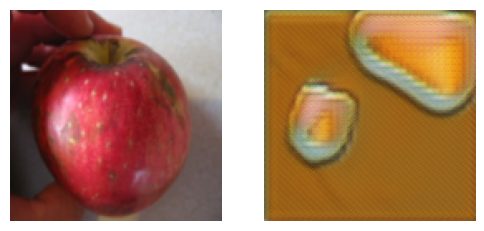

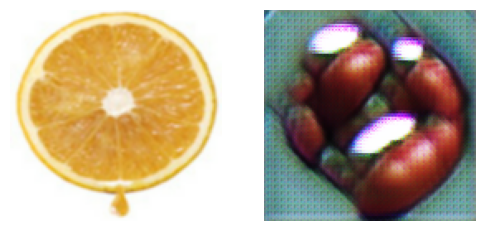

In [12]:
def denorm(x):
    x = (x+1.0)*127.5
    return tf.cast(tf.clip_by_value(x,0,255), tf.uint8)

xa = next(iter(testA_imgs))[0]
xb = next(iter(testB_imgs))[0]
yB = G_AB(xa[None,...], training=False)[0]
yA = G_BA(xb[None,...], training=False)[0]

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(denorm(xa).numpy())
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(denorm(yB).numpy())
plt.show()

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(denorm(xb).numpy())
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(denorm(yA).numpy())
plt.show()


In [13]:
import shutil, os
os.makedirs("/kaggle/working/outputs", exist_ok=True)

def grid(inp, out, fn):
    fig = plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.axis('off'); plt.imshow(denorm(inp).numpy())
    plt.subplot(1,2,2); plt.axis('off'); plt.imshow(denorm(out).numpy())
    fig.savefig(fn, bbox_inches='tight'); plt.close(fig)

itA_eval = iter(testA_imgs)
itB_eval = iter(testB_imgs)

for i in range(1,4):
    xa = next(itA_eval)[0]; yB = G_AB(xa[None,...], training=False)[0]
    grid(xa, yB, f"/kaggle/working/outputs/apple_to_orange_{i}.png")

for i in range(1,4):
    xb = next(itB_eval)[0]; yA = G_BA(xb[None,...], training=False)[0]
    grid(xb, yA, f"/kaggle/working/outputs/orange_to_apple_{i}.png")

shutil.make_archive("/kaggle/working/outputs_cycleGAN", "zip", "/kaggle/working/outputs")
print("OK")


OK
